Importing required libraries.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import glob

1) Making a function that reads video file and converts that into 4D array of appropiate size

In [2]:
def loadVideo(filename):
    #Loading Video
    vidcap = cv2.VideoCapture(filename)
    #Getting frames count
    count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))-1
    #Reading image by image
    success,image = vidcap.read()
    #Creating a numpy array to place whole video in it
    #8 bit color resolution
    videoRGBFramesGray = np.zeros([count, image.shape[0], image.shape[1], image.shape[2]], dtype=np.uint8)
    for i in range(0, count):
        #cv2.imwrite("Parsed_Images/frame%d.jpg" % count, image)     # save frame as JPEG file  
        success, image = vidcap.read()
        videoRGBFramesGray[i,:,:,:] = image  
    return videoRGBFramesGray

2) A function that loads video from the given path in 4D array.

In [3]:
myVideo = loadVideo('Videos/road.mp4')

In [4]:
print(myVideo.shape)

(425, 720, 1280, 3)


3)  A function for finding mean frame and std frame.

In [5]:
def findVideoFramesMean(imgSequenceRGB):
    meanImg = np.zeros([imgSequenceRGB.shape[1], imgSequenceRGB.shape[2], imgSequenceRGB.shape[3]])
    for color in range(0, imgSequenceRGB.shape[3]):
        for y in range(0, imgSequenceRGB.shape[1]):
            for x in range(0, imgSequenceRGB.shape[2]):
                meanImg[y, x, color] = np.array((np.mean(imgSequenceRGB[:, y, x, color])), dtype=np.uint8)
    return np.array((meanImg), dtype=np.uint8)

In [6]:
meanFrame = findVideoFramesMean(myVideo) 

In [7]:
print(np.max(meanFrame))
print(np.max(myVideo[1, :, :, :]))

254
255


In [8]:
def findVideoFramesSTD(imgSequenceRGB):
    meanImg = np.zeros([imgSequenceRGB.shape[1], imgSequenceRGB.shape[2], imgSequenceRGB.shape[3]])
    for color in range(0, imgSequenceRGB.shape[3]):
        for y in range(0, imgSequenceRGB.shape[1]):
            for x in range(0, imgSequenceRGB.shape[2]):
                meanImg[y, x, color] = np.array((np.std(imgSequenceRGB[:, y, x, color])), dtype=np.uint8)
    return meanImg

In [9]:
stdFrame = findVideoFramesSTD(myVideo) 

In [10]:
print(stdFrame.shape)

(720, 1280, 3)


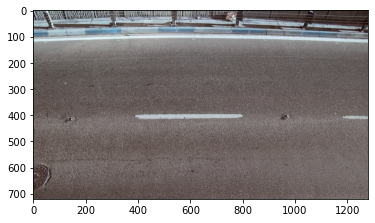

In [11]:
plt.imshow(meanFrame)
plt.show()

4)  A function that takes background clip for model training, and video on which we want to remove background. This function takes confidence bound in terms of standard deviation bound.

In [12]:
def findBackgroundRemoved(imgSequenceRGB, imgBackgroundSequenceRGB, multiplierSTD):
    meanFrameSequence = findVideoFramesMean(imgBackgroundSequenceRGB[:,:,:,:]) 
    stdFrameSequence  = (findVideoFramesSTD(imgBackgroundSequenceRGB[:,:,:,:]))*multiplierSTD
    backgroundRemovedSequence = imgSequenceRGB
    tuning = 25
    for depth in range(0, imgSequenceRGB.shape[0]):
        for y in range(0, imgSequenceRGB.shape[1]):
            for x in range(0, imgSequenceRGB.shape[2]):
                if((meanFrameSequence[y, x, 0] - stdFrameSequence[y, x, 0] - tuning <= imgSequenceRGB[depth, y, x, 0] <= meanFrameSequence[y, x, 0] + stdFrameSequence[y, x, 0] + tuning))and((meanFrameSequence[y, x, 1] - stdFrameSequence[y, x, 1] - tuning <= imgSequenceRGB[depth, y, x, 1] <= meanFrameSequence[y, x, 1] + stdFrameSequence[y, x, 1] + tuning))and((meanFrameSequence[y, x, 2] - stdFrameSequence[y, x, 2] - tuning <= imgSequenceRGB[depth, y, x, 2] <= meanFrameSequence[y, x, 2] + stdFrameSequence[y, x, 2] + tuning)):
                    backgroundRemovedSequence[depth, y, x, :] = np.zeros((3), dtype=np.uint8) #Tues Testing 1
        print("Image number is :" + str(depth+1))
    return backgroundRemovedSequence

In [13]:
def findCleanFrame(image):
    outputImageShape = image.shape
    for x in range(1, outputImageShape[1]):
        if(np.std(image[:, x])<1):
            image[:, x] = np.zeros((image.shape[0]), dtype=np.uint8)
    for y in range(1, outputImageShape[0]):
        if(np.std(image[:, x])<1):
            image[y, :] = np.zeros((image.shape[1]), dtype=np.uint8)
    return image
    

In [14]:
def findBetterBackgroundRemoved(imgSequenceRGB, imgBackgroundSequenceRGB, multiplierSTD):
    meanFrameSequence = findVideoFramesMean(imgBackgroundSequenceRGB[:,:,:,:]) 
    print("Done with computing mean.")
    stdFrameSequence  = (findVideoFramesSTD(imgBackgroundSequenceRGB[:,:,:,:]))*multiplierSTD
    print("Done with standard deviation.")
    backgroundRemovedSequence = imgSequenceRGB
    tuning = 25
    for depth in range(0, imgSequenceRGB.shape[0]):
        for y in range(0, imgSequenceRGB.shape[1]):
            for x in range(0, imgSequenceRGB.shape[2]):
                if((meanFrameSequence[y, x, 0] - stdFrameSequence[y, x, 0] - tuning <= imgSequenceRGB[depth, y, x, 0] <= meanFrameSequence[y, x, 0] + stdFrameSequence[y, x, 0] + tuning))and((meanFrameSequence[y, x, 1] - stdFrameSequence[y, x, 1] - tuning <= imgSequenceRGB[depth, y, x, 1] <= meanFrameSequence[y, x, 1] + stdFrameSequence[y, x, 1] + tuning))and((meanFrameSequence[y, x, 2] - stdFrameSequence[y, x, 2] - tuning <= imgSequenceRGB[depth, y, x, 2] <= meanFrameSequence[y, x, 2] + stdFrameSequence[y, x, 2] + tuning)):
                    backgroundRemovedSequence[depth, y, x, :] = np.zeros((3), dtype=np.uint8) #Tues Testing 1
        print("Image generated number is :" + str(depth+1))
        backgroundRemovedSequence[depth, :, :, 0] = findCleanFrame(np.array(((backgroundRemovedSequence[depth, :, :, 0])), dtype = np.uint8))
        backgroundRemovedSequence[depth, :, :, 1] = findCleanFrame(np.array(((backgroundRemovedSequence[depth, :, :, 1])), dtype = np.uint8))
        backgroundRemovedSequence[depth, :, :, 2] = findCleanFrame(np.array(((backgroundRemovedSequence[depth, :, :, 2])), dtype = np.uint8))
        #plt.imshow(backgroundRemovedSequence[depth, :, :, :])
        #plt.show()
        print("Image filtered number is :" + str(depth+1))
    return backgroundRemovedSequence

In [15]:
myVideoBackgroundRemoved = findBackgroundRemoved(myVideo[0:425,:,:,:], myVideo[0:50,:,:,:], 3)

Image number is :1
Image number is :2
Image number is :3
Image number is :4
Image number is :5
Image number is :6
Image number is :7
Image number is :8
Image number is :9
Image number is :10
Image number is :11
Image number is :12
Image number is :13
Image number is :14
Image number is :15
Image number is :16
Image number is :17
Image number is :18
Image number is :19
Image number is :20
Image number is :21
Image number is :22
Image number is :23
Image number is :24
Image number is :25
Image number is :26
Image number is :27
Image number is :28
Image number is :29
Image number is :30
Image number is :31
Image number is :32
Image number is :33
Image number is :34
Image number is :35
Image number is :36
Image number is :37
Image number is :38
Image number is :39
Image number is :40
Image number is :41
Image number is :42
Image number is :43
Image number is :44
Image number is :45
Image number is :46
Image number is :47
Image number is :48
Image number is :49
Image number is :50
Image num

Image number is :397
Image number is :398
Image number is :399
Image number is :400
Image number is :401
Image number is :402
Image number is :403
Image number is :404
Image number is :405
Image number is :406
Image number is :407
Image number is :408
Image number is :409
Image number is :410
Image number is :411
Image number is :412
Image number is :413
Image number is :414
Image number is :415
Image number is :416
Image number is :417
Image number is :418
Image number is :419
Image number is :420
Image number is :421
Image number is :422
Image number is :423
Image number is :424
Image number is :425


5)	A function to write output video to the memory with given path, name, frames per second.

In [16]:
def writeVideo(imgSequenceRGB, fps, filename):
    frameSize = (imgSequenceRGB.shape[2], imgSequenceRGB.shape[1])
    out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, (frameSize))
    for i in range(0, imgSequenceRGB.shape[0]):
        out.write(imgSequenceRGB[i,:, :, :])
    out.release()

In [17]:
fps = 25
writeVideo(myVideoBackgroundRemoved, fps, "output_video_road.avi")